In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import read_roi
from read_roi import read_roi_zip
from collections import OrderedDict
import pathlib
from pyometiff import OMETIFFReader
import skimage as ski
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean

In [29]:
import glob, os

dir_path = "/Users/letroter.a/Desktop/calimglia/expe/"

for root, dirs, files in os.walk(dir_path):
    i = 0
    for file in files:
        if file.endswith('.DS_Store'):
            path = os.path.join(root, file)

            print("Deleting: %s" % (path))

            if os.remove(path):
                print("Unable to delete!")
            else:
                print("Deleted...")
                i += 1

print("Files Deleted: %d" % (i))

Deleting: /Users/letroter.a/Desktop/calimglia/expe/.DS_Store
Deleted...
Deleting: /Users/letroter.a/Desktop/calimglia/expe/slice2_L2_20X/.DS_Store
Deleted...
Files Deleted: 1


In [31]:
import pandas as pd

df = pd.DataFrame()

timepoint = 100 
downsample_factor_x_y = 4
downsample_factor_t = 50

xform = np.eye(4)
xform_mask = np.eye(4)
hdr = nib.Nifti1Header()

list_exp = os.listdir(dir_path)

for exp in list_exp:
    print("experience: ", exp)

    list_files = os.listdir(os.path.join(dir_path,str(exp)))

    for file in list_files:
      if file.endswith(".zip"):
        print("read ROI")
          
        zip_file = os.path.join( dir_path , str(exp) , "RoiSet.zip")
        
        mask_number = 0
        mask_shape = ((128, 128))
        polygon_list = []
        all_masks = np.zeros(mask_shape)
    
        if (os.path.isfile(zip_file)):
            
            my_rois = read_roi.read_roi_zip(zip_file)

            for i in my_rois.keys():
                print(my_rois[i]['name'], my_rois[i]['type'])
                if (my_rois[i]['type']=='oval'):
                    print("ROI skipped")
                    
                if (my_rois[i]['type']=='freehand'):

                    mask_number = mask_number + 1
                    new_polygon = []
                    print("ROI ", mask_number, "freehand founded ")
    
                    for n in range(0,len(my_rois[i]['x'])):
                        new_polygon.append([my_rois[i]['x'][n] / downsample_factor_x_y ,my_rois[i]['y'][n] / downsample_factor_x_y  ])

                    if (len(new_polygon)> 0):
                        polygon_list.append(new_polygon)                            
                        mask = ski.draw.polygon2mask(mask_shape, polygon_list[mask_number-1])
                        mask.astype(int)
                        mask_downscaled = rescale(mask, 1, anti_aliasing=False)         
                        mask_labeled = mask_downscaled.astype(int) * mask_number
                        mask_label = np.zeros(mask_shape)
                        mask_label = np.add(mask_label,mask_downscaled)
                        mask_label_nii = nib.Nifti1Image(mask_label, xform_mask,hdr)

                        mask_label_nii_name_ds_x_y_t = os.path.join( dir_path + str(exp) ,'mask' + str(mask_number) +'.nii.gz' )
                        
                        nib.save(mask_label_nii, mask_label_nii_name_ds_x_y_t)
                        
                        all_masks = np.add(all_masks,mask_labeled)

        all_masks_nii = nib.Nifti1Image(all_masks, xform_mask,hdr)
        allmask_filename = dir_path + '/' + str(exp) + '/labels.nii.gz' 
        nib.save(all_masks_nii, allmask_filename)

      if file.endswith(".ome.tiff"):
        img_ometif_name = dir_path + '/' + str(exp) + '/'  + str(file)
        img_fpath = pathlib.Path(img_ometif_name)
        filename_nii_ds_x_y_t = file.replace(".ome.tiff", "_ds.nii.gz")
        ome_to_nii_name_ds_x_y_t = os.path.join(dir_path,str(exp),str(downsample_factor_x_y)+'_'+str(downsample_factor_t)+'_'+filename_nii_ds_x_y_t)
        print(ome_to_nii_name_ds_x_y_t)
        print("convert",img_fpath,"to", filename_nii_ds_x_y_t)

        check_file = os.path.exists(ome_to_nii_name_ds_x_y_t)

        if (not check_file):
            reader = OMETIFFReader(fpath=img_fpath)
            img_array, metadata, xml_metadata = reader.read()
            img_array_flip = np.swapaxes(img_array,2,0)
            img_array_downscaled = downscale_local_mean(img_array_flip, (downsample_factor_x_y, downsample_factor_x_y, downsample_factor_t) )
            img_array_downscaled_res = np.reshape(img_array_downscaled, (img_array_downscaled.shape[0], img_array_downscaled.shape[1], 1, img_array_downscaled.shape[2]))
            convert_ome_to_nii_downscaled = nib.Nifti1Image(img_array_downscaled_res, xform)
            print(img_array_downscaled_res.shape)
            nib.save(convert_ome_to_nii_downscaled, ome_to_nii_name_ds_x_y_t)




experience:  slice1_L2_20X
/Users/letroter.a/Desktop/calimglia/expe/slice1_L2_20X/4_50_0_2_ds.nii.gz
convert /Users/letroter.a/Desktop/calimglia/expe/slice1_L2_20X/0_2.ome.tiff to 0_2_ds.nii.gz
/Users/letroter.a/Desktop/calimglia/expe/slice1_L2_20X/4_50_0_3_ds.nii.gz
convert /Users/letroter.a/Desktop/calimglia/expe/slice1_L2_20X/0_3.ome.tiff to 0_3_ds.nii.gz
/Users/letroter.a/Desktop/calimglia/expe/slice1_L2_20X/4_50_0_5_ds.nii.gz
convert /Users/letroter.a/Desktop/calimglia/expe/slice1_L2_20X/0_5.ome.tiff to 0_5_ds.nii.gz
/Users/letroter.a/Desktop/calimglia/expe/slice1_L2_20X/4_50_0_4_ds.nii.gz
convert /Users/letroter.a/Desktop/calimglia/expe/slice1_L2_20X/0_4.ome.tiff to 0_4_ds.nii.gz
read ROI
0001-0330-0280 freehand
ROI  1 freehand founded 
0636-0336-0286 freehand
ROI  2 freehand founded 
0636-0100-0328 oval
ROI skipped
0001-0181-0341 freehand
ROI  3 freehand founded 
0001-0345-0211 oval
ROI skipped
0734-0094-0132 oval
ROI skipped
2663-0296-0416 oval
ROI skipped
/Users/letroter.a/Des

In [ ]:
#import scipy
#scipy.optimize.curve_fit(lambda t,a,b: a*numpy.exp(b*t),  x,  y,  p0=(4, 0.1))

In [73]:
#import ants
import os
import numpy   as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [74]:
def read_image_nii(folder, index ):
  mask = nib.load(os.path.join( folder , 'mask' + str(index) + '.nii.gz'))
  mask_data=mask.get_fdata()
  return (mask_data)

In [75]:
for exp in list_exp:
    print("experience: ", exp)

experience:  slice1_L2_20X
experience:  slice2_L2_20X


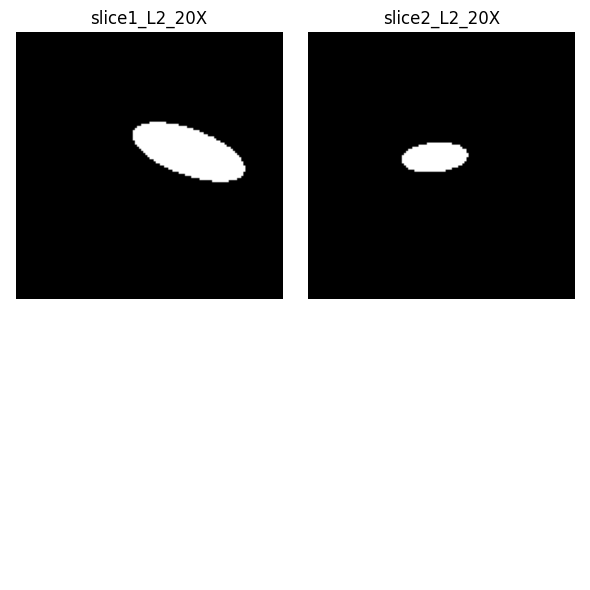

True

In [117]:
index_source = 1
index_target = 2

mask_data_src=read_image_nii( os.path.join( dir_path ,"slice1_L2_20X"), index_source)
mask_data_target=read_image_nii( os.path.join( dir_path ,"slice2_L2_20X"), index_target)

plt.figure(figsize=(6,6))
plt.axis('Off')
plt.subplot(2,2,1)
plt.imshow(mask_data_src, cmap="gray", origin="lower")
plt.title('slice1_L2_20X')
plt.axis('off')
plt.subplot(2,2,2)
plt.title("slice2_L2_20X")
plt.imshow(mask_data_target, cmap="gray", origin="lower")
plt.axis('Off')
plt.tight_layout()
plt.show()

# Filename
filename = 'test.jpg'
uint_img = np.array(mask_data_src*255).astype('uint8')

cv2.imwrite(filename, uint_img)

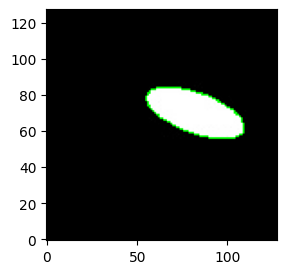

In [132]:
image=cv2.imread(filename)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
edges = cv.Canny(gray,100,200)
contours, hierarchy = cv.findContours(edges, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
ellipse = cv2.fitEllipse(max(contours,key=cv2.contourArea))
cv2.ellipse(image,ellipse,(0,255,0),1)

plt.figure(figsize=(3,3))
plt.imshow(image, cmap="gray", origin="lower")
plt.show()

In [69]:
(xc, yc), (width, height), angle = genEllipse
rminor = min(width, height) / 2
xtop = xc + math.cos(math.radians(angle)) * rminor
ytop = yc + math.sin(math.radians(angle)) * rminor
cv2.line(result, (int(xtop), int(ytop)), (int(xc), int(yc)), (0, 0, 255), 3)

NameError: name 'genEllipse' is not defined

In [ ]:
fig=plt.figure(figsize=(5,5))  
plt.title("histogram on full dataset after arPLS correction")
plt.xlabel('times')
plt.ylabel('expe number')

width=150
# Paramètres pour l'échelle de couleur
vmin = 0
vmax = .5

all_spectra_arPLS_select_cum[0:20]=0
print(all_spectra_arPLS_select_cum.shape)
expe = plt.imshow(all_spectra_arPLS_select_cum.reshape(all_spectra_arPLS_select_cum.shape[0]//width,width), cmap='hot', aspect='auto', vmin=vmin, vmax=vmax)
fig.colorbar(expe)

plt.savefig(dir_path +'heatmap.pdf')



In [ ]:
#Plot data
fig, axs = plt.subplots(1,2,figsize=(16,9) )

facto_s = np.percentile(all_spectra_select[1:149],50)
axs[0].plot(all_spectra_select[1:149]/facto_s, label='all neurons manually segmented')

facto_b = np.percentile(all_spectra_random[1:149],50)
#axs[0].plot(all_spectra_random[1:149]/facto_b, label='random background')
axs[0].set_title('before baseline correction')
axs[0].set_ylabel('raw signals')
axs[0].set_xlabel('time')
axs[0].legend()

#asymmetrically reweighted Penalized Least Squares (arPLS)
axs[1].plot(all_spectra_arPLS_substrated_normalized[1:149], label='all neurons manually segmented')
#ax3.plot(all_spectra_arPLS_background[1:149], label='background')
#axs[1].plot(all_spectra_arPLS_random[1:149], label='random background')
axs[1].set_title('after arPLS baseline correction')
axs[1].set_ylabel('corrected signals')
axs[1].set_xlabel('time')
axs[1].legend()

fig.suptitle('cumulative histogram on entire dataset')


plt.show()


In [ ]:
fig3, ax3 = plt.subplots( nrows=1, ncols=1 )  # create figure & 1 axis

all_spectra_arPLS_substrated_normalized[0:20]=0

ax3.plot(all_spectra_arPLS_substrated_normalized[1:149], label='all neurons')
plt.xlabel('times')
plt.ylabel('corrected signals')
plt.title('cumulative histogram after baseline correction (arPLS)')
ax3.legend()
fig3.show()

plt.savefig(dir_path +'hist_cum.pdf')

In [ ]:
#display the DataFrame
df_norm

In [ ]:
df.to_csv(dir_path + '/results_raw.csv', index=False) 
df_norm.to_csv(dir_path + '/results_norm.csv', index=False) 

In [ ]:
 #filename_nii = file.replace(".ome.tiff", "_nlm.nii.gz")
                #filename_nii_ds = file.replace(".ome.tiff", "_ds.nii.gz")
                #ome_to_nii_name = dir_path + '/' + str(exp) + '/'  + filename_nii
                #ome_to_nii_name_ds = dir_path + '/' + str(exp) + '/'  + filename_nii_ds
                #img_array_flip_mean = np.mean(img_array_flip[:,:,:], axis = 2)
                #img_array_flip_mean_downscaled = downscale_local_mean(img_array_flip_mean, (2, 2) )
                #stack_average_ome_to_nii = nib.Nifti1Image(img_array_flip_mean, xform)
                #nib.save(stack_average_ome_to_nii, ome_to_nii_name)
                #stack_average_ome_to_nii_ds = nib.Nifti1Image(img_array_flip_mean_downscaled, xform)
                #nib.save(stack_average_ome_to_nii_ds, ome_to_nii_name_ds)  
                